# Домашнее задание 6: классификация текстов

В этом домашнем задании вам предстоит построить классификатор текстов!

Данные мы будем использовать из Kaggle соревнования: https://www.kaggle.com/competitions/nlp-getting-started/data Оттуда надо скачать файл train.csv. На обучающую и тестовую выборки его поделим кодом ниже, менять его не надо!

Мы будем работать с датасетом постов из твиттера. Нам предстоит решать задачу бинарной классификации - определять содержатся ли в твитте информация о настоящей катастрофе/инциденте или нет.

In [28]:
!pip install nltk
!pip install re

You should consider upgrading via the 'c:\users\крот\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


ERROR: Could not find a version that satisfies the requirement re (from versions: none)
ERROR: No matching distribution found for re
You should consider upgrading via the 'c:\users\крот\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [29]:
import pandas as pd

In [30]:
data = pd.read_csv('train.csv')

In [31]:
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [32]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.3, random_state=42)

## Задание 1 (0.5 балла)

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их пустой строкой.

In [33]:
train.isna().sum()

id             0
keyword       44
location    1760
text           0
target         0
dtype: int64

In [34]:
test.isna().sum()

id            0
keyword      17
location    773
text          0
target        0
dtype: int64

In [35]:
train = train.fillna("")
test = test.fillna("")

## Задание 2 (1 балл)
Давайте немного посмотрим на наши данные. Визуализируйте (где явно просят) или выведете информацию о следующем:

1. Какое распределение классов в обучающей выборке?
2. Посмотрите на колонку "keyword" - возьмите 10 наиболее встречающихся значений, постройте ступенчатую диаграмму распределения классов в зависимости от значения keyword, сделайте выводы.

In [36]:
import numpy as np
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', 30)

In [37]:
train["target"].value_counts()

0    3024
1    2305
Name: target, dtype: int64

In [38]:
ind = train["keyword"].value_counts().head(10).index

In [39]:
df_new = pd.DataFrame(train[['keyword','target']].value_counts())
df_new = df_new.reset_index()
df_new.head(15)

,keyword,target,0
0,wreckage,1,34
1,,1,32
2,siren,0,31
3,electrocute,0,27
4,screaming,0,27
5,ruin,0,27
6,twister,0,27
7,typhoon,1,27
8,fear,0,27
9,deluge,0,26


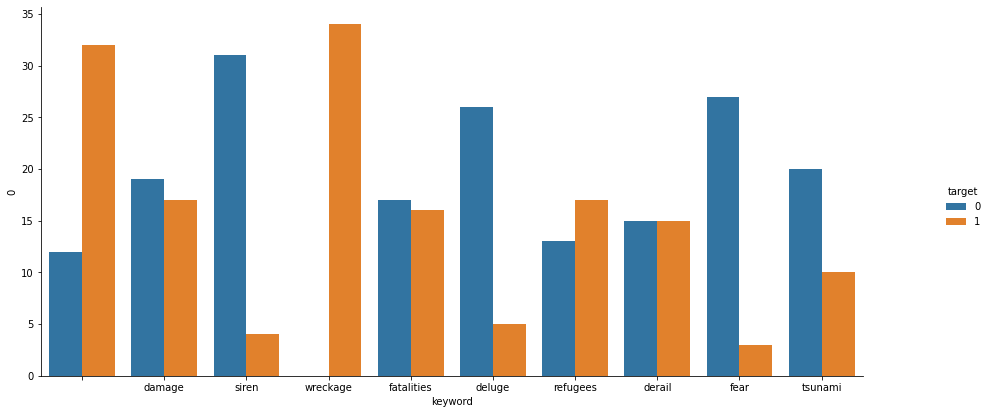

In [40]:
import seaborn as sn

g = sn.catplot(x="keyword",y=0,hue = 'target',data=df_new[df_new['keyword'].isin(ind)],kind="bar",order = ind)
g.fig.set_size_inches(15,6)

Классов под номером "0" больше, чем под номером "1". Однако, она "непрекошена".

## Задание 3 (0.5 балла) 

В этом задании предлагается объединить все три текстовых столбца в один (просто сконкатенировать cтроки) и убрать столбец с индексом.

In [41]:
text = pd.DataFrame(train[['keyword','location','text']].apply("".join, axis=1))
target = pd.DataFrame(train['target'])
train_n =pd.concat([text,target],axis=1)

text = pd.DataFrame(test[['keyword','location','text']].apply("".join, axis=1))
target = pd.DataFrame(test['target'])
test_n =pd.concat([text,target],axis=1)
train_n.rename(columns={0:'text'},inplace=True)
test_n.rename(columns={0:'text'},inplace=True)
train_n.head()

,text,target
1186,bridge%20collapseAshes 2015: AustraliaÛªs col...,0
4071,"hailCarol Stream, IllinoisGREAT MICHIGAN TECHN...",1
5461,policeHouston CNN: Tennessee movie theater sho...,1
5787,riotingStill rioting in a couple of hours left...,1
7445,woundsLake HighlandsCrack in the path where I ...,0


## Задание 4 (0.5 балла)

Далее мы будем пока работать только с train частью.

1. Предобработайте данные (train часть) с помощью CountVectorizer.
2. Какого размера получилась матрица?


In [42]:
from sklearn.feature_extraction.text import CountVectorizer
cnt_vec = CountVectorizer()
X = cnt_vec.fit_transform(train_n['text'])

In [43]:
print('Кол-во хранимых эелементов:',X.nnz)
X.shape

Кол-во хранимых эелементов: 84366


(5329, 22738)

## Задание 5 (1 балл)

В предыдущем пункте у вас должна была получиться достаточно большая матрица.
Если вы взгляните на текст, то увидете, что там есть множество специальных символов, ссылок и прочего мусора.

Давайте также посмотрим на словарь, который получился в результате построения CountVectorizer, его можно найти в поле vocabulary_ инстанса этого класса. Давайте напишем функцию, которая печает ответы на следующие вопросы:

1. Найдите в этом словаре все слова, которые содержат цифры. Сколько таких слов нашлось?

2. Найдите все слова, которые содержат символы пунктуации. Сколько таких слов нашлось? 

3. Сколько хэштегов (токен начинается на #) и упоминаний (токен начинается на @) осталось в словаре?

In [44]:
def ans(l):
    num = 0
    punct = 0
    htags = 0
    rem = 0
    for x in l:
        if x.replace(' ','').isalnum():
            if any(map(str.isdigit,x)):
                num += 1
        else:
            punct +=1
        if x[0] == '#':
            htags +=1
        if x[0] == '@':
            rem +=1
            print(x)
    return {'Слов, содержащих цифры': num,
            'Слов, содержащих знаки пунктуации':punct,
            'Слов-хештегов':htags, 
            'Слов-упоминаний':rem}        

In [45]:
ans(cnt_vec.get_feature_names())

c:\users\крот\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


{'Слов, содержащих цифры': 4539,
 'Слов, содержащих знаки пунктуации': 317,
 'Слов-хештегов': 0,
 'Слов-упоминаний': 0}

## Задание 6 (0.5 балла)

Вспомним, что на семинаре по текстам мы узнали, что в nltk есть специальный токенизатор для текстов - TweetTokenizer. Попробуем применить CountVectorizer с этим токенизатором. Ответьте на все вопросы из предыдущего пункта для TweetTokenizer и сравните результаты.

In [46]:
from nltk.tokenize import TweetTokenizer
# Чтобы узнать, какие параметры есть у этого токенайзера - используйте help(TweetTokenizer)
# Для того, чтобы передать токенайзер в CountVectorizer используйте параметр tokenizer
# text = "".join(list(train_n['text']))
tok = TweetTokenizer()
tok = tok.tokenize
cnt_vec = CountVectorizer(analyzer='word',tokenizer = tok)
X_1 = cnt_vec.fit_transform(list(train_n['text']))

In [47]:
print('Кол-во хранимых эелементов:',X_1.nnz)
X_1.shape

Кол-во хранимых эелементов: 91791


(5329, 23874)

In [48]:
ans(cnt_vec.get_feature_names())

@
@1
@1061thetwister
@115film
@15moferadio
@1acd4900c1424d1
@1rockstar62
@2
@20skyhawkmm20
@233liveonline
@300000
@4tiles
@50shadezofgrey
@5sos
@666canberra
@8
@957thegame
@95roots
@9newsbrisbane
@9newsgoldcoast
@_301dc
@__scrambledeggs
@__srajapakse__
@_ashj
@_asianshawtyy
@_bookofdaniel
@_charleyisqueen
@_chelsdelong12
@_dangdaddy
@_dmerida
@_edvinnn
@_explicitpretty
@_freemarketeer
@_gaabyx
@_itsmegss_
@_itzsteven
@_keits
@_minimehh
@_pokemoncards_
@_stiiilo
@_wildfire__
@aace_org
@aaronthefm
@abandonedpics
@abbyairshow
@abc
@abc7
@abc7chicago
@abcnews
@abcnews24
@abcnorio
@ablaze
@abninfvet
@abran_caballero
@abysmaljoiner
@acaciapenn
@accionempresa
@acebabes
@acebreakingnews
@acmilan
@adamnibloe
@adamrubinespn
@adamtuss
@adanne___
@adndotcom
@adrian_peel
@adriasimon_
@adultblackmale
@aelinrhee
@afk_10
@afp
@aftershock_delo
@ag_usa
@ageekyfangirl14
@ahhtheenikki
@aida_de
@aiginsurance
@aitchkaycee
@ajabrown
@akcsl
@akgovbillwalker
@alamodc
@alanhahn
@alaska
@alcoholandmetal
@aleisst

@slsandpet
@smh
@smoak_queen
@snapharmony
@snazzychipz
@so
@solelinks
@sonisoner
@sonofbobbob
@sonoranrattler
@sonyprousa
@soonergrunt
@soonermagic_
@sophieingle01
@sorry
@soundcloud
@southridgelife
@soyeh
@space_wolverine
@spencer_fearon
@spencers
@spinningbot
@spookyfob
@sport_en
@squibby_
@ssssnell
@stacdemon
@stacedemon
@stallion150
@stankyboy88
@starbucks
@startelegram
@startide
@stationcdrkelly
@stavernise
@steel_lord
@steph93065
@stevenontwatter
@steveycheese99
@stfxuniversity
@stickynyc
@stonebrewingco
@stormbeard
@strawberrysoryu
@stretcher
@strickskin
@stunckle
@stupid_niggr
@stury
@stvmlly
@summerhallery
@sundercr
@suny_orange
@supernovalester
@sureshpprabhu
@surf_photo
@suryaray
@susanj357
@sw_trains
@swayoung01
@swb1192
@sweet2young
@sweetiebirks
@swellyjetevo
@swiftycommissh
@symbolicjensen
@syringetoanger
@szmnextdoor
@taaylordarr
@tackettdc
@tadhgtgmtel
@talkinghell
@tammy_w1997
@taoistinsight
@taraswart
@tareksocal
@target
@tarleton_sophie
@taufikcj
@taxstone
@tayiorrm

{'Слов, содержащих цифры': 1243,
 'Слов, содержащих знаки пунктуации': 7589,
 'Слов-хештегов': 1474,
 'Слов-упоминаний': 1678}

## Задание 7 (2 балла)

В scikit-learn мы можем оценивать процесс подсчета матрицы через CountVectorizer. У CountVectorizer, как и у других наследников \_VectorizerMixin, есть аргумент tokenizer и preprocessor. preprocessor применится в самом начале к каждой строке вашего датасета, tokenizer же должен принять строку и вернуть токены.
Давайте напишем кастомный токенайзер, которые сделает все, что нам нужно: 

0. Приведет все буквы к нижнему регистру
1. Разобьет текст на токены с помощью TweetTokenizer из пакета nltk
2. Удалит все токены содержащие не латинские буквы, кроме смайликов (будем считать ими токены содержащие только пунктуацию и, как минимум, одну скобочку) и хэштегов, которые после начальной # содержат только латинские буквы.
3. Удалит все токены, которые перечислены в nltk.corpus.stopwords.words('english')
4. Проведет стемминг с помощью SnowballStemmer

Продемонстрируйте работу вашей функции на первых десяти текстах в обучающей выборке.

In [49]:
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Крот\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [50]:
from nltk.corpus import stopwords
from string import punctuation
from nltk.stem.snowball import SnowballStemmer
import re

def token(line):
    line = line.lower()
#     tok = TweetTokenizer()
    line = TweetTokenizer().tokenize(line)
    line_tokens = []
    for x in line:
        if x not in stopwords.words('english'):
            if not all(map(lambda y: re.search(r'[0-9a-z]',y),x)):
                if x[0] =='#' and x[1:].isalpha():
                    line_tokens.append(x)
                elif ((')' in x or '(' in x) and all(map(lambda y: y in punctuation,x))):
                    line_tokens.append(x)
            else:
                line_tokens.append(x)
    stemmer = SnowballStemmer('english')
    line_stemmed = [stemmer.stem(w) for w in line_tokens] 
    line = list(set(line_stemmed))
    return line

In [51]:
train_n['tokens'] = list(map(token,list(train_n['text'])))

In [52]:
pd.DataFrame(train_n['tokens'].head(10))

,tokens
1186,"[histori, england, australia, 2015, trent, wor..."
4071,"[techniqu, thank, michigan, illinoisgreat, b1g..."
5461,"[shoot, kill, movi, policehouston, suspect, po..."
5787,"[coupl, left, hour, riot, class, riotingstil]"
7445,"[morn, elbow, path, beach, woundslak, surfac, ..."
151,"[island, french, reunion, debri, air, found, e..."
915,"[killer, kill, bloodyisol, citi, boast, came, ..."
1305,"[burn, realli, idk, except]"
2570,"[), destroyh, hous, (, destroy, ask]"
7399,"[shot, exchang, wound, venezuelapolic, wounded..."


## Задание 8 (1 балл)

1. Примените CountVectorizer с реализованным выше токенизатором к обучающим и тестовым выборкам.
2. Обучите LogisticRegression на полученных признаках.
3. Посчитайте метрику f1-score на тестовых данных.

In [53]:
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import f1_score

In [54]:
cnt_vec = CountVectorizer(analyzer='word',tokenizer = token)
X_train = cnt_vec.fit_transform(list(train_n['text']))
X_test =  cnt_vec.transform(list(test_n['text']))

In [55]:
ans(cnt_vec.get_feature_names())

c:\users\крот\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


{'Слов, содержащих цифры': 1221,
 'Слов, содержащих знаки пунктуации': 1340,
 'Слов-хештегов': 1329,
 'Слов-упоминаний': 0}

In [56]:
y_train = list(train_n['target'])
y_test =list(test_n['target'])

In [57]:
clf = LogisticRegression(max_iter=1000, random_state=50)
clf.fit(X_train, y_train)
pred_thrgramm = clf.predict(X_test)
print(f1_score(y_test, pred_thrgramm))

0.7377139701822197


In [58]:
print('Кол-во хранимых эелементов:',X_train.nnz)
X_train.shape

Кол-во хранимых эелементов: 51626


(5329, 15070)

## Задание 9 (1 балл)

1. Повторите 7 задание, но с tf-idf векторизатором. Как изменилось качество?
2. Мы можем еще сильнее уменьшить размер нашей матрицы, если отбросим значения df близкие к единице. Скорее всего такие слова не несут много информации о категории, так как встречаются достаточно часто. Ограничьте максимальный df в параметрах TfIdfVectorizer, поставьте верхнюю границу равную 0.9. Как изменился размер матрицы, как изменилось качество?
3. Также мы можем уменьшить размер матрицы, удаляя слова со слишком маленьким df. Удалось ли добиться улучшения качества? 

In [59]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfdf_vec = TfidfVectorizer(analyzer='word',tokenizer = token)
Xtf_train = tfdf_vec.fit_transform(list(train_n['text']))
Xtf_test =  tfdf_vec.transform(list(test_n['text']))

In [60]:
print('Кол-во хранимых эелементов:',Xtf_train.nnz)
Xtf_train.shape

Кол-во хранимых эелементов: 51626


(5329, 15070)

In [61]:
clf = LogisticRegression(max_iter=200, random_state=42)
clf.fit(Xtf_train, y_train)
pred_thrgramm = clf.predict(Xtf_test)
print(f1_score(y_test, pred_thrgramm))

0.7366628830874007


Качество упало  по сравнению с CountVectorizer


##### С верхней границей df = 0.9 

In [62]:
tfdf_vec1 = TfidfVectorizer(analyzer='word',tokenizer = token,max_df = 0.9)
Xtf_train1 = tfdf_vec1.fit_transform(list(train_n['text']))
Xtf_test1 =  tfdf_vec1.transform(list(test_n['text']))

In [63]:
clf = LogisticRegression(max_iter=200, random_state=42)
clf.fit(Xtf_train1, y_train)
pred_thrgramm = clf.predict(Xtf_test1)
print(f1_score(y_test, pred_thrgramm))

0.7366628830874007


In [64]:
print('Кол-во хранимых эелементов:',Xtf_train1.nnz)
Xtf_train1.shape

Кол-во хранимых эелементов: 51626


(5329, 15070)

Не улучшилось

##### С верхней границей df = 0.9  и нижней - 0.001 

In [65]:
tfdf_vec2 = TfidfVectorizer(analyzer='word',tokenizer = token,max_df = 0.9,min_df=0.001)
Xtf_train2 = tfdf_vec2.fit_transform(list(train_n['text']))
Xtf_test2 =  tfdf_vec2.transform(list(test_n['text']))

In [66]:
clf = LogisticRegression(max_iter=200, random_state=42)
clf.fit(Xtf_train2, y_train)
pred_thrgramm = clf.predict(Xtf_test2)
print(f1_score(y_test, pred_thrgramm))

0.7383073496659243


In [67]:
print('Кол-во хранимых эелементов:',Xtf_train2.nnz)
Xtf_train2.shape

Кол-во хранимых эелементов: 32818


(5329, 1634)

## Задание 10 (1 балл)

Еще один популяпный трюк, который позволит уменьшить количество признаков называется hashing trick. Его суть в том, то мы случайно группируем признаки ииии  ..... складываем их! А потом удаляем исходные признаки. В итоге все наши признаки это просто суммы исходных. Звучит странно, но это отлично работает. Давайте проверим этот трюк в нашем сеттинге.
Также при таком подходе вам не нужно хранить словарь token->index, что тоже иногда полезно.

1. Повторите задание 7 с HashingVectorizer, укажите количество фичей равное 5000.
2. Какой из подходов показал самый высокий результат?

In [68]:
from sklearn.feature_extraction.text import HashingVectorizer
h_vec = HashingVectorizer(analyzer='word',tokenizer = token,n_features=5000)
Xh_train = h_vec.fit_transform(list(train_n['text']))
Xh_test =  h_vec.transform(list(test_n['text']))

c:\users\крот\appdata\local\programs\python\python39\lib\site-packages\sklearn\feature_extraction\text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [69]:
clf.fit(Xh_train, y_train)
pred_thrgramm = clf.predict(Xh_test)
print(f1_score(y_test, pred_thrgramm))

0.7056154282473057


In [70]:
print('Кол-во хранимых эелементов:',Xh_train.nnz)
Xh_train.shape

Кол-во хранимых эелементов: 51583


(5329, 5000)

Подход с tf-idf векторизатором и с верхней границей df = 0.9  и нижней - 0.001 окоазывается наилучшим.

## Задание 11 (1 балл)

В этом задании нужно добиться f1 меры хотя в 0.75 на тестовых данных.

In [71]:
from nltk.corpus import stopwords
from string import punctuation
from nltk.stem.snowball import SnowballStemmer
import re

def token1(line):
    line = line.lower()
    tok = TweetTokenizer()
    line = tok.tokenize(line)
    line_tokens = []
    for x in line:
        if not all(map(lambda y: re.search(r'[0-9a-z]',y),x)):
            if x[0] =='#' and x[1:].isalpha():
                line_tokens.append(x)
            elif (')' in x or '(' in x):
                  z = x.replace(')','')
                  x = z.replace('(','')
                  if all(map(lambda y: y in punctuation,z)):
                      line_tokens.append(x)
        else:
                line_tokens.append(x)
    stemmer = SnowballStemmer('english')
    line_stemmed = [stemmer.stem(w) for w in line_tokens]
    line = list(set(line_stemmed))
    return line

In [88]:
t11_vec = CountVectorizer(analyzer='word',tokenizer = token1)
X11_train = t11_vec.fit_transform(list(train_n['text']))
X11_test =  t11_vec.transform(list(test_n['text']))

In [91]:
forclf = LogisticRegression(max_iter=1000, random_state=50)
clf.fit(X11_train, y_train)
pred_thrgramm = clf.predict(X11_test)
print(f1_score(y_test, pred_thrgramm))

0.7552140504939626
